In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from math import atanh, sqrt
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # matches Overleaf lmodern
    "mathtext.fontset": "cm",
    "text.latex.preamble": r"\usepackage{lmodern}\usepackage{amsmath}"
})


pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 14)

# Load Data

## Load Embeddings

In [3]:
audience_embeddings = pd.read_parquet("NLP Data/Audience Embeddings/rt_audience_embeddings_aggregated.parquet")
critic_embeddings = pd.read_parquet("NLP Data/Critic Embeddings/rt_critic_embeddings_aggregated.parquet")

print(f"Number of movies in audience embeddings data: {audience_embeddings.shape[0]}",
      f"\nNumber of movies in critic embeddings data: {critic_embeddings.shape[0]}")

Number of movies in audience embeddings data: 9116 
Number of movies in critic embeddings data: 9116


## Load Valence Data

In [4]:
audience_valence = pd.read_json("NLP Data/Audience Sentiment Data/rt_audience_valence_aggregated.json")
critic_valence = pd.read_json("NLP Data/Critic Sentiment Data/rt_critic_valence_aggregated.json")

print(f"Number of movies in audience valence data: {audience_valence.shape[0]}",
      f"\nNumber of movies in critic valence data: {critic_valence.shape[0]}")

Number of movies in audience valence data: 9116 
Number of movies in critic valence data: 9116


## Load Ratings

In [5]:
audience_ratings = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Audience Reviews Clean/rt_audience_reviews_clean_{i}.json") for i in range(25)]).groupby("id").agg(AvgAudienceRating = ("ratingOutOfTen", "mean")).reset_index()

critic_ratings = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Critic Reviews Clean/rt_critic_reviews_clean_{i}.json") for i in range(20)]).groupby("id").agg(AvgCriticRating = ("ratingOutOfTen", "mean")).reset_index()

print(f"Number of movies in audience rating data: {audience_ratings.shape[0]}",
      f"\nNumber of movies in critic rating data: {critic_ratings.shape[0]}")

Number of movies in audience rating data: 9116 
Number of movies in critic rating data: 9116


## Load 'Tomato-Meter' and 'Popcorn-Meter'

In [6]:
tomato_meter, popcorn_meter = (pd.read_json("Rotten Tomatoes Reviews/rt_movies_clean.json").pipe(lambda df: (df[["id", "tomatoMeter"]], df[["id", "audienceScore"]])))

tomato_meter.dropna(subset=["tomatoMeter"], inplace=True)

popcorn_meter.dropna(subset=["audienceScore"], inplace=True)

print(f"Number of movies in audience score data: {popcorn_meter.shape[0]}",
      f"\nNumber of movies in Tomato-Meter data: {tomato_meter.shape[0]}")

Number of movies in audience score data: 9062 
Number of movies in Tomato-Meter data: 9112


# Similarity of Valence Metrics

## 'Tomato-Meter' and 'Popcorn-Meter' on Average Dataset Ratings

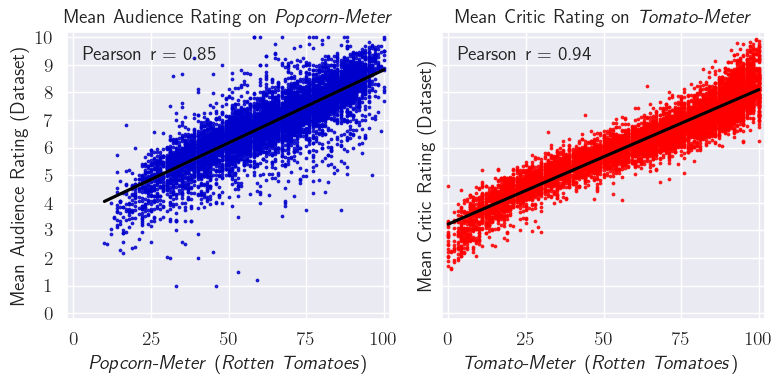

Hypthesis Test Audience: t-statistic = 0.8479444097861527, p-value = 0.0 
Hypothesis Test Critics: t-statistic = 0.9430777473698142, p-value = 0.0


In [7]:
# Should be similar, since audience score is the average rating across all audience reviews
# Tomato-Meter is the percentage of critics awarding a 'fresh' rating to the movie
plot_data0 = popcorn_meter.merge(right=audience_ratings, how="left", on="id")


sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

sns.regplot(x=plot_data0["audienceScore"],
            y=plot_data0["AvgAudienceRating"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="mediumblue",
            ax=axes[0])

corr0 = plot_data0["audienceScore"].corr(plot_data0["AvgAudienceRating"])

axes[0].text(0.05, 0.95, s=f"Pearson r = {corr0:.2f}", transform=axes[0].transAxes, verticalalignment="top", fontsize=14)

axes[0].set_title("Mean Audience Rating on \emph{Popcorn-Meter}", fontsize=14)
axes[0].set_ylabel("Mean Audience Rating (Dataset)", fontsize=14)
axes[0].set_xlabel("\emph{Popcorn-Meter} (\emph{Rotten Tomatoes})", fontsize=14)

plot_data1 = tomato_meter.merge(right=critic_ratings, how="left", on="id")

sns.regplot(x=plot_data1["tomatoMeter"],
            y=plot_data1["AvgCriticRating"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="red",
            ax=axes[1])

corr1 = plot_data1["tomatoMeter"].corr(plot_data1["AvgCriticRating"])

axes[1].text(0.05, 0.95, s=f"Pearson r = {corr1:.2f}", transform=axes[1].transAxes, verticalalignment="top", fontsize=14)

axes[1].set_title("Mean Critic Rating on \emph{Tomato-Meter}", fontsize=14)
axes[1].set_ylabel("Mean Critic Rating (Dataset)", fontsize=14)
axes[1].set_xlabel("\emph{Tomato-Meter} (\emph{Rotten Tomatoes})", fontsize=14)

for i in range(2):
    axes[i].set_ylim((-0.2, 10.2))
    axes[i].set_xlim((-2, 102))
    axes[i].set_yticks(range(11))
    axes[i].tick_params(axis="x", labelsize=14)
    axes[i].tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.show()


# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(plot_data0["AvgAudienceRating"], plot_data0["audienceScore"], alternative="two-sided")

tstat1, pval1 = stats.pearsonr(plot_data1["AvgCriticRating"], plot_data1["tomatoMeter"], alternative="two-sided")

print(f"Hypthesis Test Audience: t-statistic = {tstat0}, p-value = {pval0}",
      f"\nHypothesis Test Critics: t-statistic = {tstat1}, p-value = {pval1}")

## Textual Review Sentiment on Average Dataset Ratings

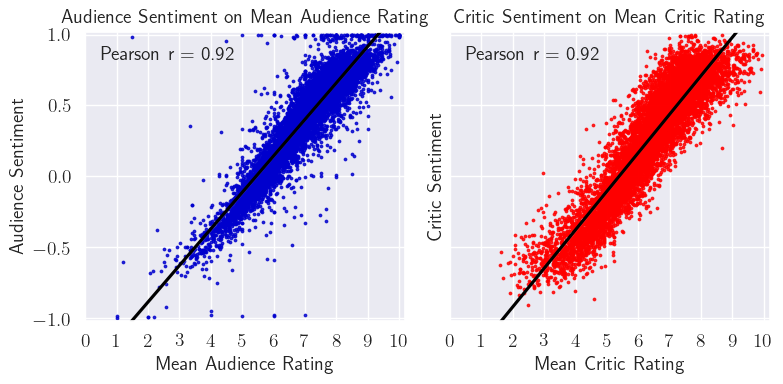

Hypthesis Test Audience: t-statistic = 0.9199211805793281, p-value = 0.0 
Hypothesis Test Critics: t-statistic = 0.917579996178832, p-value = 0.0


In [8]:
sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

sns.regplot(x=audience_ratings.sort_values("id")["AvgAudienceRating"],
            y=audience_valence.sort_values("id")["AvgValence"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="mediumblue",
            ax=axes[0])

corr0 = audience_ratings.sort_values("id")["AvgAudienceRating"].corr(audience_valence.sort_values("id")["AvgValence"])

axes[0].text(0.05, 0.95, s=f"Pearson r = {corr0:.2f}", transform=axes[0].transAxes, verticalalignment="top", fontsize=14)


axes[0].set_title("Audience Sentiment on Mean Audience Rating", fontsize=14)
axes[0].set_xlabel("Mean Audience Rating", fontsize=14)
axes[0].set_ylabel("Audience Sentiment", fontsize=14)



sns.regplot(x=critic_ratings.sort_values("id")["AvgCriticRating"],
            y=critic_valence.sort_values("id")["AvgValence"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="red",
            ax=axes[1])

axes[1].set_title("Critic Sentiment on Mean Critic Rating", fontsize=14)
axes[1].set_xlabel("Mean Critic Rating", fontsize=14)
axes[1].set_ylabel("Critic Sentiment", fontsize=14)

corr1 = critic_ratings.sort_values("id")["AvgCriticRating"].corr(critic_valence.sort_values("id")["AvgValence"])

axes[1].text(0.05, 0.95, s=f"Pearson r = {corr1:.2f}", transform=axes[1].transAxes, verticalalignment="top", fontsize=14)


for i in range(2):
    axes[i].set_ylim((-1.02, 1.02))
    axes[i].set_xlim((0, 10.2))
    axes[i].set_xticks(range(11))
    axes[i].tick_params(axis="x", labelsize=14)
    axes[i].tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.show()

# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(audience_ratings.sort_values("id")["AvgAudienceRating"], audience_valence.sort_values("id")["AvgValence"], alternative="two-sided")

tstat1, pval1 = stats.pearsonr(critic_ratings.sort_values("id")["AvgCriticRating"], critic_valence.sort_values("id")["AvgValence"], alternative="two-sided")

print(f"Hypthesis Test Audience: t-statistic = {tstat0}, p-value = {pval0}",
      f"\nHypothesis Test Critics: t-statistic = {tstat1}, p-value = {pval1}")

## Textual Review Sentiment on 'Tomato-Meter' / 'Popcorn-Meter'

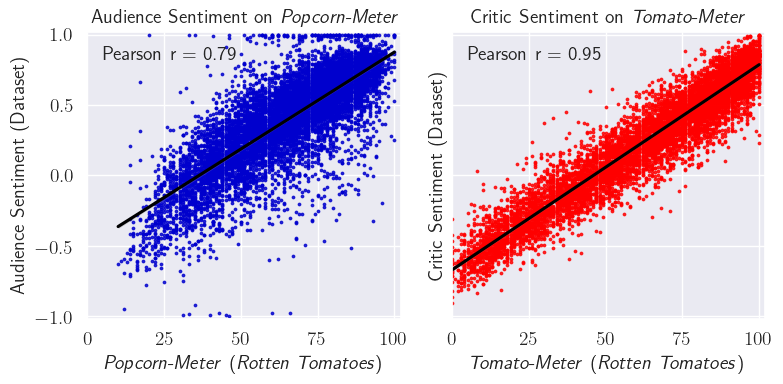

Hypthesis Test Audience: t-statistic = 0.7883579606449207, p-value = 0.0 
Hypothesis Test Critics: t-statistic = 0.9520125922018042, p-value = 0.0


In [9]:
sns.set_theme(style="darkgrid")

plot_data0 = popcorn_meter.merge(right=audience_valence, how="left", on="id")

fig, axes = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)

sns.regplot(x=plot_data0["audienceScore"],
            y=plot_data0["AvgValence"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="mediumblue",
            ax=axes[0])

corr0 = plot_data0["audienceScore"].corr(plot_data0["AvgValence"])

axes[0].text(0.05, 0.95, s=f"Pearson r = {corr0:.2f}", transform=axes[0].transAxes, verticalalignment="top", fontsize=14)


axes[0].set_title("Audience Sentiment on \emph{Popcorn-Meter}", fontsize=14)
axes[0].set_xlabel("\emph{Popcorn-Meter} (\emph{Rotten Tomatoes})", fontsize=14)
axes[0].set_ylabel("Audience Sentiment (Dataset)", fontsize=14)


plot_data1 = tomato_meter.merge(right=critic_valence, how="left", on="id")

sns.regplot(x=plot_data1["tomatoMeter"],
            y=plot_data1["AvgValence"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="red",
            ax=axes[1])

corr1 = plot_data1["tomatoMeter"].corr(plot_data1["AvgValence"])

axes[1].text(0.05, 0.95, s=f"Pearson r = {corr1:.2f}", transform=axes[1].transAxes, verticalalignment="top", fontsize=14)


axes[1].set_title("Critic Sentiment on \emph{Tomato-Meter}", fontsize=14)
axes[1].set_xlabel("\emph{Tomato-Meter} (\emph{Rotten Tomatoes})", fontsize=14)
axes[1].set_ylabel("Critic Sentiment (Dataset)", fontsize=14)

for i in range(2):
    axes[i].set_ylim((-1.02, 1.02))
    axes[i].set_xlim((0, 102))
    axes[i].tick_params(axis="x", labelsize=14)
    axes[i].tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.show()


# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(plot_data0["audienceScore"], plot_data0["AvgValence"], alternative="two-sided")

tstat1, pval1 = stats.pearsonr(plot_data1["tomatoMeter"], plot_data1["AvgValence"], alternative="two-sided")

print(f"Hypthesis Test Audience: t-statistic = {tstat0}, p-value = {pval0}",
      f"\nHypothesis Test Critics: t-statistic = {tstat1}, p-value = {pval1}")

# Merge 'Audience' and 'Critic' Datasets

## Merge 'Audience' and 'Critic' Embeddings

In [10]:
combined_embeddings = pd.merge(left=audience_embeddings.rename(columns={"embeddings": "AudienceEmbeddings"}),
                    right=critic_embeddings.rename(columns={"embeddings": "CriticEmbeddings"}),
                    on="id",
                    how="outer")
combined_embeddings.set_index("id", inplace=True)
combined_embeddings.sort_index(inplace=True)

print(f"Number of rows in combined_embeddings: {combined_embeddings.shape[0]}")
combined_embeddings.head()

Number of rows in combined_embeddings: 9116


,AudienceEmbeddings,CriticEmbeddings
id,,
10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ..."
1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ..."
10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,..."
10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,..."
10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -..."


## Merge 'Audience' and 'Critic' Valence Data

In [11]:
combined_valence = pd.merge(left=audience_valence.rename(columns={"AvgValence": "AvgAudienceValence"}),
                            right=critic_valence.rename(columns={"AvgValence": "AvgCriticValence"}),
                             on="id",
                             how="outer")
combined_valence.set_index("id", inplace=True)
combined_valence.sort_index(inplace=True)

print(f"Number of rows in combined_valence: {combined_valence.shape[0]}")
combined_valence.head()

Number of rows in combined_valence: 9116


,AvgAudienceValence,AvgCriticValence
id,,
10000_bc,-0.208172,-0.410251
1000218-accident,0.534362,0.424794
10002516-lost_city,0.567837,-0.158982
10002635-bridge_of_san_luis_rey,-0.028470,-0.647940
10003276-criminal,0.313468,0.281749


## Merge 'Audience' and 'Critic' Rating Data

In [12]:
combined_ratings = pd.merge(left=audience_ratings,
                            right=critic_ratings,
                             on="id",
                             how="outer")
combined_ratings.set_index("id", inplace=True)
combined_ratings.sort_index(inplace=True)

print(f"Number of rows in combined_ratings: {combined_ratings.shape[0]}")
combined_ratings.head()

Number of rows in combined_ratings: 9116


,AvgAudienceRating,AvgCriticRating
id,,
10000_bc,4.710843,3.503401
1000218-accident,7.642857,7.772727
10002516-lost_city,7.020000,4.964423
10002635-bridge_of_san_luis_rey,5.900000,3.196429
10003276-criminal,6.556000,6.510274


## Merge 'Tomato Meter' and 'Popcorn-Meter' Data

In [13]:
combined_rt_meter = pd.merge(left=popcorn_meter,
                            right=tomato_meter,
                             on="id",
                             how="outer")
combined_rt_meter.set_index("id", inplace=True)
combined_rt_meter.sort_index(inplace=True)

print(f"Number of rows in combined_rt_val: {combined_rt_meter.shape[0]}")
combined_rt_meter.head()

Number of rows in combined_rt_val: 9113


,audienceScore,tomatoMeter
id,,
10000_bc,37.0,9.0
1000218-accident,72.0,75.0
10002516-lost_city,64.0,26.0
10002635-bridge_of_san_luis_rey,36.0,4.0
10003276-criminal,57.0,69.0


# Calculate Divergence/Similarity Metrics

## Calculate Cosine Similarity

In [14]:
combined_embeddings["CosineSimilarity"] = combined_embeddings.apply(lambda row: cosine_similarity([row["AudienceEmbeddings"]], [row["CriticEmbeddings"]])[0][0], axis=1)
combined_embeddings.head()

,AudienceEmbeddings,CriticEmbeddings,CosineSimilarity
id,,,
10000_bc,"[-0.03942528087599016, 0.0032700514138010463, ...","[-0.029380889835797338, 0.013254167158585324, ...",0.902636
1000218-accident,"[-0.02399500713051696, -0.0307859453792584, -0...","[-0.00709496159106493, -0.020565725524128147, ...",0.901405
10002516-lost_city,"[-0.03502643047207676, 0.010035118767642416, -...","[-0.006343667547931729, -0.007982953772821192,...",0.888783
10002635-bridge_of_san_luis_rey,"[-0.01785140314605087, -0.025767731200903653, ...","[-0.014915107875519121, -0.009466946428195419,...",0.810171
10003276-criminal,"[-0.052772209397953705, -0.027951262337912338,...","[-0.036120476975689784, -0.0379468278341188, -...",0.898567


## Create Column Containing Difference of Average Audience and Critic Sentiment

In [15]:
combined_valence["ValenceDifference"] = (combined_valence["AvgAudienceValence"] - combined_valence["AvgCriticValence"])

combined_valence.head()

,AvgAudienceValence,AvgCriticValence,ValenceDifference
id,,,
10000_bc,-0.208172,-0.410251,0.202079
1000218-accident,0.534362,0.424794,0.109568
10002516-lost_city,0.567837,-0.158982,0.726819
10002635-bridge_of_san_luis_rey,-0.028470,-0.647940,0.619471
10003276-criminal,0.313468,0.281749,0.031719


## Create Column Containing Difference of Average Audience and Critic Rating

In [16]:
combined_ratings["RatingDifference"] = (combined_ratings["AvgAudienceRating"] - combined_ratings["AvgCriticRating"])

combined_ratings.head()

,AvgAudienceRating,AvgCriticRating,RatingDifference
id,,,
10000_bc,4.710843,3.503401,1.207442
1000218-accident,7.642857,7.772727,-0.129870
10002516-lost_city,7.020000,4.964423,2.055577
10002635-bridge_of_san_luis_rey,5.900000,3.196429,2.703571
10003276-criminal,6.556000,6.510274,0.045726


## Create Column Containing Difference between 'Tomato Meter' and 'Popcorn-Meter'

In [17]:
combined_rt_meter["RtValDifference"] = (combined_rt_meter["audienceScore"] - combined_rt_meter["tomatoMeter"])

combined_rt_meter.dropna(subset=["RtValDifference"], inplace=True)

combined_rt_meter.head()

,audienceScore,tomatoMeter,RtValDifference
id,,,
10000_bc,37.0,9.0,28.0
1000218-accident,72.0,75.0,-3.0
10002516-lost_city,64.0,26.0,38.0
10002635-bridge_of_san_luis_rey,36.0,4.0,32.0
10003276-criminal,57.0,69.0,-12.0


# Valence Disagreement

## Distribution of Rating Difference

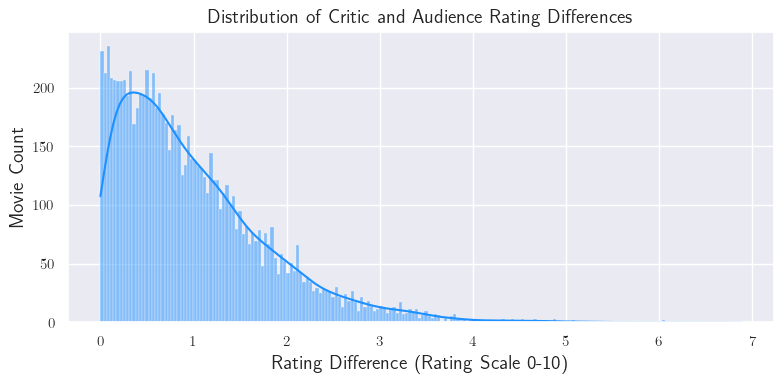

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="darkgrid")

sns.histplot(combined_ratings["RatingDifference"].abs(), color="dodgerblue", bins=200, kde=True, kde_kws={"cut": 0, "clip": (0,10), "bw_adjust": 1.2}, ax=ax)
ax.set_title("Distribution of Critic and Audience Rating Differences", fontsize=14)
ax.set_xlabel("Rating Difference (Rating Scale 0-10)", fontsize=14)
ax.set_ylabel("Movie Count", fontsize=14)

plt.tight_layout()
plt.show()

## Distribution of Textual Sentiment Difference

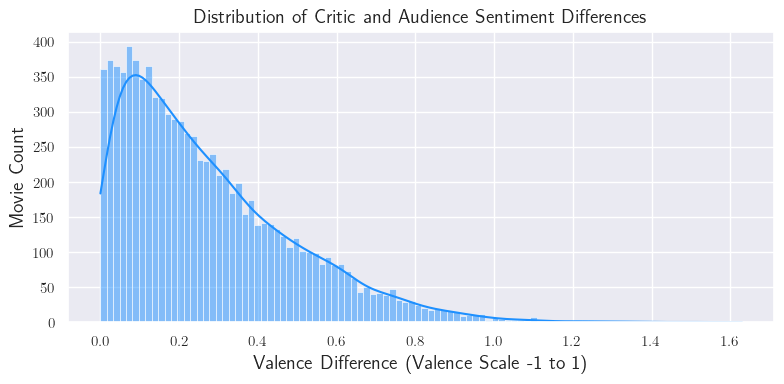

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="darkgrid")

sns.histplot(combined_valence["ValenceDifference"].abs(), color="dodgerblue", bins=100, kde=True, kde_kws={"cut": 0, "clip": (0,10), "bw_adjust": 1.2}, ax=ax)
ax.set_title("Distribution of Critic and Audience Sentiment Differences", fontsize=14)
ax.set_xlabel("Valence Difference (Valence Scale -1 to 1)", fontsize=14)
ax.set_ylabel("Movie Count", fontsize=14)

plt.tight_layout()
plt.show()

## Distribution of 'Tomato Meter' / 'Popcorn-Meter' Difference

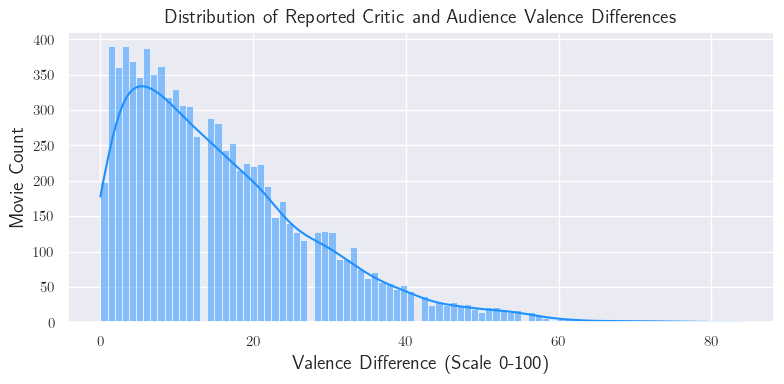

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="darkgrid")

sns.histplot(combined_rt_meter["RtValDifference"].abs(), color="dodgerblue", bins=90, kde=True, kde_kws={"cut": 0, "clip": (0,100), "bw_adjust": 1.2}, ax=ax)
ax.set_title("Distribution of Reported Critic and Audience Valence Differences", fontsize=14)
ax.set_xlabel("Valence Difference (Scale 0-100)", fontsize=14)
ax.set_ylabel("Movie Count", fontsize=14)

plt.tight_layout()
plt.show()

# Cosine Similarity Distribution

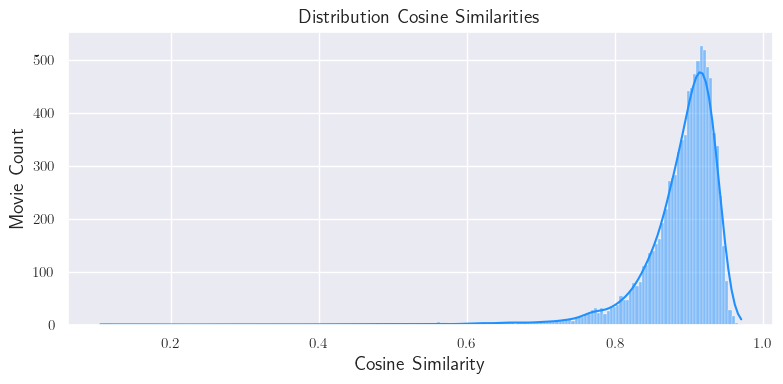

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
sns.set_theme(style="darkgrid")

sns.histplot(combined_embeddings["CosineSimilarity"].abs(), color="dodgerblue", kde=True, kde_kws={"cut": 0, "clip": (0,1), "bw_adjust": 1.2}, bins=200, ax=ax)
ax.set_title("Distribution Cosine Similarities", fontsize=14)
ax.set_xlabel("Cosine Similarity", fontsize=14)
ax.set_ylabel("Movie Count", fontsize=14)

plt.tight_layout()
plt.show()

# Valence Disagreement on Review Content Divergence

## Relationship between Review Content Divergence and Rating Differences

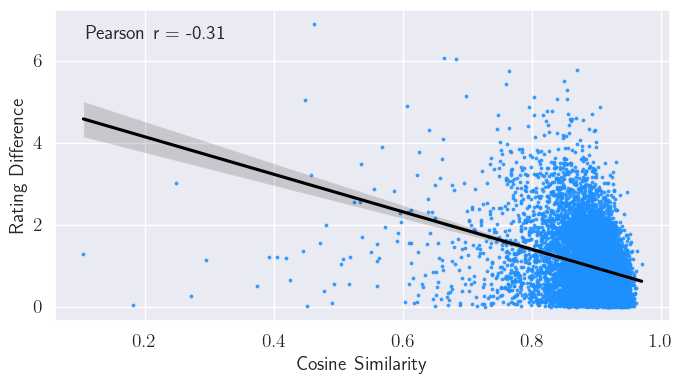

Hypthesis H₀: No Correlation
t-statistic = -0.3066856897911434, p-value = 8.821508878208086e-198


In [22]:
fig, ax = plt.subplots(figsize = (7,4))
sns.set_theme(style="darkgrid")

sns.regplot(x=combined_embeddings.sort_values("id")["CosineSimilarity"], 
            y=combined_ratings.sort_values("id")["RatingDifference"].abs(),
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            color="dodgerblue",
            ax=ax)

#ax.set_title("Review Similarity on Rating Difference", fontweight="bold", fontsize=16)
ax.set_xlabel("Cosine Similarity", fontsize=14)
ax.set_ylabel("Rating Difference", fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

corr = combined_embeddings["CosineSimilarity"].corr(combined_ratings["RatingDifference"].abs())
ax.text(0.05, 0.95, s=f"Pearson r = {corr:.2f}", transform=ax.transAxes, verticalalignment="top", fontsize=14)

plt.tight_layout()
plt.show()

# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(combined_embeddings.sort_values("id")["CosineSimilarity"], combined_ratings.sort_values("id")["RatingDifference"].abs(), alternative="two-sided")

print(f"Hypthesis H₀: No Correlation\nt-statistic = {tstat0}, p-value = {pval0}")

### Positive / Negative Difference (Higher Rated by Audiences/Higher Rated by Critics)

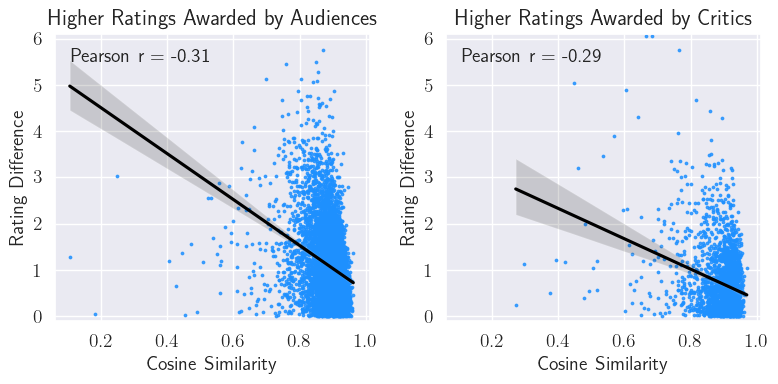

Hypthesis Audience Rating > Critic Rating: t-statistic = -0.30682347613141614, p-value = 3.524976724667594e-144 
Hypothesis Critic Rating > Audience Rating: t-statistic = -0.2906029571219848, p-value = 6.923118586158946e-50

H₀: ρ₁ = ρ₂ 
H₁: ρ₁ ≠ ρ₂ 
z-statistic: -0.7584516543906517 
p-value: 0.44818064482002784


In [23]:
plot_data0 = combined_ratings[combined_ratings["RatingDifference"] >= 0].merge(right=combined_embeddings, how="left", on="id")

fig, axes = plt.subplots(1,2, figsize = (8,4), sharex=True)
sns.set_theme(style="darkgrid")

#fig.suptitle("Review Similarity on Rating Difference", fontweight= "bold", fontsize=16)

sns.regplot(x=plot_data0["CosineSimilarity"], 
            y=plot_data0["RatingDifference"],
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            color="dodgerblue",
            ax=axes[0])

axes[0].set_title("Higher Ratings Awarded by Audiences", fontweight="bold", fontsize=16)


corr0 = plot_data0["CosineSimilarity"].corr(plot_data0["RatingDifference"])
axes[0].text(0.05, 0.95, s=f"Pearson r = {corr0:.2f}", transform=axes[0].transAxes, verticalalignment="top", fontsize=14)

plot_data1 = combined_ratings[combined_ratings["RatingDifference"] < 0].merge(right=combined_embeddings, how="left", on="id")


sns.regplot(x=plot_data1["CosineSimilarity"], 
            y=plot_data1["RatingDifference"].abs(),
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            color="dodgerblue",
            ax=axes[1])

axes[1].set_title("Higher Ratings Awarded by Critics", fontweight="bold", fontsize=16)


corr1 = plot_data1["CosineSimilarity"].corr(plot_data1["RatingDifference"].abs())
axes[1].text(0.05, 0.95, s=f"Pearson r = {corr1:.2f}", transform=axes[1].transAxes, verticalalignment="top", fontsize=14)

for i in range(2):
    axes[i].set_xlabel("Cosine Similarity", fontsize=14)
    axes[i].set_ylabel("Rating Difference", fontsize=14)
    axes[i].tick_params(axis="x", labelsize=14)
    axes[i].tick_params(axis="y", labelsize=14)
    axes[i].set_ylim((-0.1, 6.1))


plt.tight_layout()
plt.show()

# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(plot_data0["CosineSimilarity"], plot_data0["RatingDifference"], alternative="two-sided")

tstat1, pval1 = stats.pearsonr(plot_data1["CosineSimilarity"], plot_data1["RatingDifference"].abs(), alternative="two-sided")

print(f"Hypthesis Audience Rating > Critic Rating: t-statistic = {tstat0}, p-value = {pval0}",
      f"\nHypothesis Critic Rating > Audience Rating: t-statistic = {tstat1}, p-value = {pval1}")


# Fisher r to z test to test for difference in correlation
# H₀: ρ₁ = ρ₂
# H₁: ρ₁ ≠ ρ₂
n1 = len(plot_data0)
n2 = len(plot_data1)

# Fisher transform
z1 = atanh(corr0)
z2 = atanh(corr1)

# Standard error
SE = sqrt(1/(n1-3) + 1/(n2-3))

# z statistic
z = (z1 - z2) / SE

# two-sided p-value
p = 2 * (1 - stats.norm.cdf(abs(z)))


print(f"\nH₀: ρ₁ = ρ₂",
      "\nH₁: ρ₁ ≠ ρ₂",
      f"\nz-statistic: {z}",
      f"\np-value: {p}")


## Relationship between Review Content Differences and Textual Sentiment Divergence

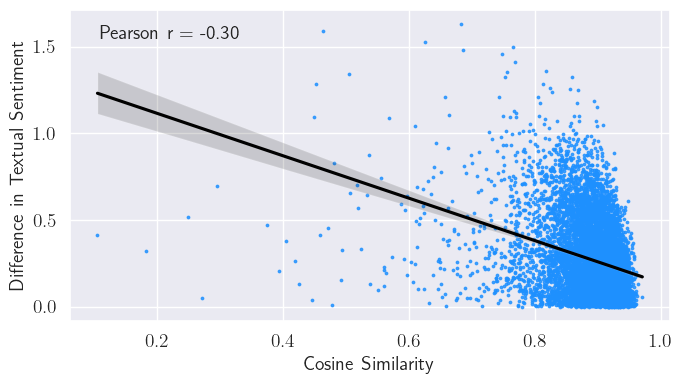

Hypthesis H₀: No Correlation
t-statistic = -0.3043628639614319, p-value = 1.1144804954697326e-194


In [24]:
fig, ax = plt.subplots(figsize = (7,4))
sns.set_theme(style="darkgrid")

sns.regplot(x=combined_embeddings.sort_values("id")["CosineSimilarity"], 
            y=combined_valence.sort_values("id")["ValenceDifference"].abs(),
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            color="dodgerblue",
            ax=ax)

#ax.set_title("Review Similarity on Difference in Textual Sentiment", fontweight="bold", fontsize=16)
ax.set_xlabel("Cosine Similarity", fontsize=14)
ax.set_ylabel("Difference in Textual Sentiment", fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

corr = combined_embeddings["CosineSimilarity"].corr(combined_valence["ValenceDifference"].abs())
ax.text(0.05, 0.95, s=f"Pearson r = {corr:.2f}", transform=ax.transAxes, verticalalignment="top", fontsize=14)

plt.tight_layout()
plt.show()


# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(combined_embeddings.sort_values("id")["CosineSimilarity"], combined_valence.sort_values("id")["ValenceDifference"].abs(), alternative="two-sided")

print(f"Hypthesis H₀: No Correlation\nt-statistic = {tstat0}, p-value = {pval0}")

## Relationship of Review Content Divergence and Difference between 'Tomato Meter'/'Popcorn-Meter'

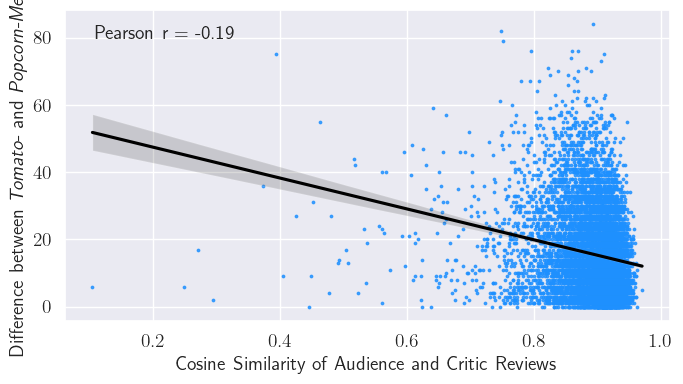

Hypthesis H₀: No Correlation
t-statistic = -0.19281337777061525, p-value = 1.2903107080064884e-76


In [25]:
plot_data = combined_rt_meter.merge(right=combined_embeddings, how="left", on="id").reset_index(drop=True)

fig, ax = plt.subplots(figsize = (7,4))
sns.set_theme(style="darkgrid")

sns.regplot(x=plot_data["CosineSimilarity"], 
            y=plot_data["RtValDifference"].abs(),
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            color="dodgerblue",
            ax=ax)

#ax.set_title("Review Similarity on Difference of \emph{Tomato-Meter} / \emph{Popcorn-Meter}", fontweight="bold", fontsize=16)
ax.set_xlabel("Cosine Similarity of Audience and Critic Reviews", fontsize=14)
ax.set_ylabel("Difference between \emph{Tomato-} and \emph{Popcorn-Meter}", fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

corr = plot_data["CosineSimilarity"].corr(plot_data["RtValDifference"].abs())
ax.text(0.05, 0.95, s=f"Pearson r = {corr:.2f}", transform=ax.transAxes, verticalalignment="top", fontsize=14)

plt.tight_layout()
plt.show()


# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(plot_data["CosineSimilarity"], plot_data["RtValDifference"].abs(), alternative="two-sided")

print(f"Hypthesis H₀: No Correlation\nt-statistic = {tstat0}, p-value = {pval0}")

## Alternative Thesis Plot

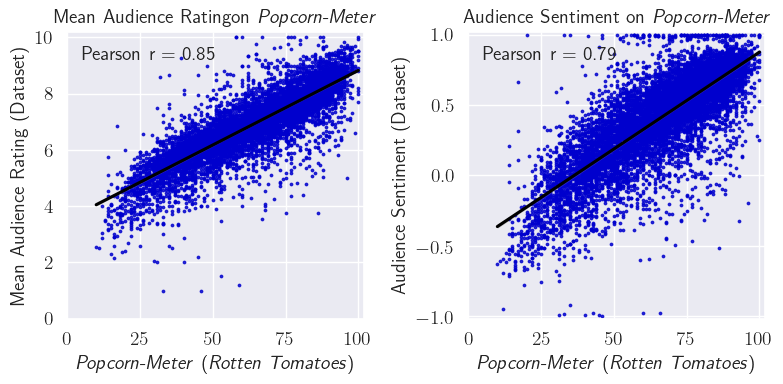

Hypthesis Test Audience: t-statistic = 0.8479444097861527, p-value = 0.0 
Hypothesis Test Critics: t-statistic = 0.7883579606449207, p-value = 0.0


In [26]:
plot_data0 = popcorn_meter.merge(right=audience_ratings, how="left", on="id")


sns.set_theme(style="darkgrid")

fig, axes = plt.subplots(1,2, figsize=(8,4), sharex=True)

sns.regplot(x=plot_data0["audienceScore"],
            y=plot_data0["AvgAudienceRating"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="mediumblue",
            ax=axes[0])

corr0 = plot_data0["audienceScore"].corr(plot_data0["AvgAudienceRating"])

axes[0].text(0.05, 0.95, s=f"Pearson r = {corr0:.2f}", transform=axes[0].transAxes, verticalalignment="top", fontsize=14)

axes[0].set_title("Mean Audience Ratingon \emph{Popcorn-Meter}", fontsize=14)
axes[0].set_ylabel("Mean Audience Rating (Dataset)", fontsize=14)
axes[0].set_xlabel("\emph{Popcorn-Meter} (\emph{Rotten Tomatoes})", fontsize=14)
axes[0].set_ylim((0,10.2))



plot_data1 = popcorn_meter.merge(right=audience_valence, how="left", on="id")

sns.regplot(x=plot_data1["audienceScore"],
            y=plot_data1["AvgValence"],
            scatter_kws={"s": 3},
            line_kws={"color": "black"},
            color="mediumblue",
            ax=axes[1])

corr1 = plot_data1["audienceScore"].corr(plot_data1["AvgValence"])

axes[1].text(0.05, 0.95, s=f"Pearson r = {corr1:.2f}", transform=axes[1].transAxes, verticalalignment="top", fontsize=14)


axes[1].set_title("Audience Sentiment on \emph{Popcorn-Meter}", fontsize=14)
axes[1].set_xlabel("\emph{Popcorn-Meter} (\emph{Rotten Tomatoes})", fontsize=14)
axes[1].set_ylabel("Audience Sentiment (Dataset)", fontsize=14)
axes[1].set_ylim((-1.02,1.02))



for i in range(2):
    axes[i].set_xlim((0, 102))
    axes[i].tick_params(axis="x", labelsize=14)
    axes[i].tick_params(axis="y", labelsize=14)

plt.tight_layout()
plt.show()



# Test  H₀: No Correlation
#       H₁: Some Correlation

tstat0, pval0 = stats.pearsonr(plot_data0["AvgAudienceRating"], plot_data0["audienceScore"], alternative="two-sided")

tstat1, pval1 = stats.pearsonr(plot_data1["AvgValence"], plot_data1["audienceScore"], alternative="two-sided")

print(f"Hypthesis Test Audience: t-statistic = {tstat0}, p-value = {pval0}",
      f"\nHypothesis Test Critics: t-statistic = {tstat1}, p-value = {pval1}")

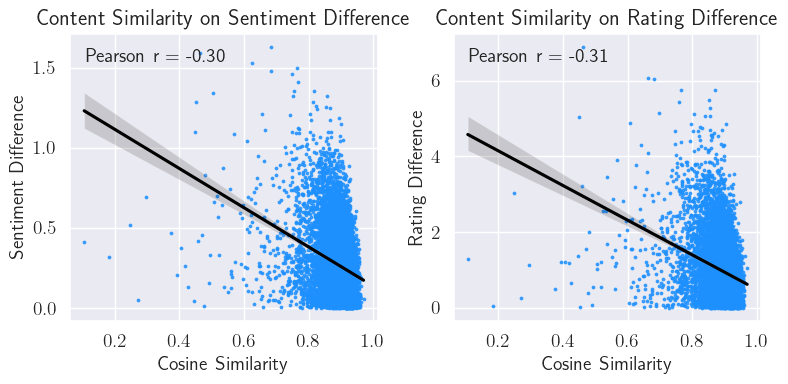

In [29]:
fig, axes = plt.subplots(1,2, figsize = (8,4))
sns.set_theme(style="darkgrid")

sns.regplot(x=combined_embeddings.sort_values("id")["CosineSimilarity"], 
            y=combined_valence.sort_values("id")["ValenceDifference"].abs(),
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            color="dodgerblue",
            ax=axes[0])

axes[0].set_title("Content Similarity on Sentiment Difference", fontweight="bold", fontsize=16)
axes[0].set_xlabel("Cosine Similarity", fontsize=14)
axes[0].set_ylabel("Sentiment Difference", fontsize=14)
axes[0].tick_params(axis="x", labelsize=14)
axes[0].tick_params(axis="y", labelsize=14)

corr = combined_embeddings["CosineSimilarity"].corr(combined_valence["ValenceDifference"].abs())
axes[0].text(0.05, 0.95, s=f"Pearson r = {corr:.2f}", transform=axes[0].transAxes, verticalalignment="top", fontsize=14)



sns.regplot(x=combined_embeddings.sort_values("id")["CosineSimilarity"], 
            y=combined_ratings.sort_values("id")["RatingDifference"].abs(),
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            color="dodgerblue",
            ax=axes[1])

axes[1].set_title("Content Similarity on Rating Difference", fontweight="bold", fontsize=16)
axes[1].set_xlabel("Cosine Similarity", fontsize=14)
axes[1].set_ylabel("Rating Difference", fontsize=14)
axes[1].tick_params(axis="x", labelsize=14)
axes[1].tick_params(axis="y", labelsize=14)

corr = combined_embeddings["CosineSimilarity"].corr(combined_ratings["RatingDifference"].abs())
axes[1].text(0.05, 0.95, s=f"Pearson r = {corr:.2f}", transform=axes[1].transAxes, verticalalignment="top", fontsize=14)


plt.tight_layout()
plt.show()